In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/MyDrive/My First Project.v15i.yolov11"

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [4]:
!pip install torch torchvision torchaudio


In [5]:
!pip install ultralytics scikit-learn opencv-python


In [6]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)


GPU Available: True
CUDA Version: 12.4


In [7]:

import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import models
import os
import shutil
import glob
from sklearn.model_selection import train_test_split


In [8]:
# Define dataset path (Update as per your dataset location)
dataset_path = "/content/drive/MyDrive/My First Project.v15i.yolov11"  # Change this if needed
train_folder = os.path.join(dataset_path, "dataset/train")

# Path to dataset YAML file
dataset_yaml = os.path.join(dataset_path, "data.yaml")

# Check if dataset YAML exists
if not os.path.exists(dataset_yaml):
    raise FileNotFoundError(f"Dataset YAML file not found: {dataset_yaml}")

print("✅ Dataset path and YAML verified!")


✅ Dataset path and YAML verified!


In [9]:
def organize_dataset():
    """Verifies dataset structure without moving files and checks label correspondence."""
    image_exts = ['.jpg', '.jpeg', '.png']
    label_ext = '.txt'

    # Get all image and label file names in the training folder
    image_files = [f for f in os.listdir(train_folder) if any(f.endswith(ext) for ext in image_exts)]
    label_files = [f.replace(os.path.splitext(f)[1], label_ext) for f in image_files]  # Convert to .txt filenames

    # Check if all images have corresponding labels
    missing_labels = [img for img in image_files if img.replace(os.path.splitext(img)[1], label_ext) not in os.listdir(train_folder)]

    if missing_labels:
        print(f"⚠ Warning: {len(missing_labels)} images are missing labels!")
        for img in missing_labels[:5]:  # Show only first 5 missing
            print(f"   - {img} (No corresponding .txt file)")

    print("✅ Dataset verified successfully! No need to move files.")

    # Returning file lists (no splitting since data is pre-split)
    return image_files, label_files


In [10]:
# Custom Backbone using ResNet50
class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()

        # Load pretrained ResNet50 model
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # Remove the last FC and avgpool layers
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze all pretrained layers (optional: can be unfrozen for fine-tuning)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.feature_extractor(x)

print("✅ Custom ResNet50 Backbone Defined!")


✅ Custom ResNet50 Backbone Defined!


In [11]:
# Extend YOLOv10n model with Custom Backbone
class YOLOWithCustomBackbone(YOLO):
    def __init__(self, model_path="yolo11s.pt"):
        super().__init__(model_path)

        # Ensure the model architecture allows replacing the backbone
        if hasattr(self.model, 'model') and len(self.model.model) > 0:
            self.model.model[0] = CustomBackbone()
        else:
            raise ValueError("Backbone replacement failed! Check YOLOv10n architecture.")

print("✅ YOLOv10n with Custom ResNet50 Backbone Defined!")


✅ YOLOv10n with Custom ResNet50 Backbone Defined!


In [12]:
# Train YOLOv10n with Custom Backbone
print("🚀 Initializing YOLOv10n with Custom Backbone...")
model = YOLOWithCustomBackbone()

print("🎯 Starting Training...")
model.train(
    data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml",  # Dataset config
    epochs=70,  # Full 70 epochs training
    batch=32,  # Batch size
    imgsz=640,  # Image size
    save=True,  # Save training results
    cache=True,  # Cache dataset
    device=0,  # Use GPU
    optimizer="AdamW",  # Optimizer
    project="/content/drive/MyDrive/modcnn_results",  # Save results to Drive
    name="icratrash_modcnn",  # Experiment folder
    pretrained=True  # Use pretrained weights
)

print("✅ Training Complete! Saving best model...")
model.save("best_custom_yolo.pt")


🚀 Initializing YOLOv10n with Custom Backbone...
🎯 Starting Training...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml, epochs=70, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=8, project=/content/drive/MyDrive/modcnn_results, name=icratrash_modcnn2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/train/labels.cache... 2436 images, 420 backgrounds, 0 corrupt: 100%|██████████| 2436/2436 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (2.8GB RAM): 100%|██████████| 2436/2436 [00:21<00:00, 115.45it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.3GB RAM): 100%|██████████| 266/266 [00:02<00:00, 108.41it/s]


Plotting labels to /content/drive/MyDrive/modcnn_results/icratrash_modcnn2/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/modcnn_results/icratrash_modcnn2
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      7.98G      2.322      4.027      2.367         19        640: 100%|██████████| 77/77 [00:51<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        266        295          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      9.55G      2.264      3.435      2.383          6        640: 100%|██████████| 77/77 [00:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]

                   all        266        295      0.266     0.0226     0.0027   0.000859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      9.57G      2.146      3.142      2.264          6        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        266        295    0.00238      0.215    0.00204   0.000473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      9.57G      2.091      3.011      2.226         13        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


                   all        266        295      0.529     0.0427    0.00918    0.00265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      9.57G      2.049      2.799      2.147          7        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        266        295      0.567      0.105      0.015    0.00369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      9.58G      1.944      2.689      2.071          4        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        266        295      0.576     0.0951     0.0677     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      9.58G      1.872      2.549      1.973          7        640: 100%|██████████| 77/77 [00:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        266        295      0.638     0.0755     0.0537     0.0198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      9.58G      1.843      2.452      1.957          7        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        266        295      0.651      0.148     0.0857     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70       9.6G      1.811       2.41      1.929          7        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        266        295      0.599      0.182       0.13     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      9.66G      1.746       2.28      1.874         12        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        266        295      0.637      0.146      0.111     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      9.66G      1.728      2.198      1.866          5        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        266        295      0.601      0.117     0.0923     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      9.66G      1.672      2.152      1.814         11        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        266        295      0.642       0.19      0.162     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      9.68G      1.664      2.105      1.801          5        640: 100%|██████████| 77/77 [00:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


                   all        266        295      0.572      0.193      0.153     0.0524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      9.74G      1.613      2.041      1.764          7        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        266        295      0.524      0.255      0.159     0.0691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      9.74G      1.601      1.978      1.756          8        640: 100%|██████████| 77/77 [00:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

                   all        266        295      0.476       0.15      0.182     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      9.74G       1.57      1.924      1.722          9        640: 100%|██████████| 77/77 [00:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        266        295      0.219      0.222      0.153     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      9.74G      1.562      1.884      1.722         12        640: 100%|██████████| 77/77 [00:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        266        295      0.427      0.156      0.166     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      9.74G      1.564      1.851      1.719         17        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        266        295      0.267      0.264      0.213      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      9.74G      1.508      1.789      1.683          7        640: 100%|██████████| 77/77 [00:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

                   all        266        295      0.681       0.23      0.193      0.079



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      9.74G      1.468      1.726      1.659         14        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        266        295      0.357      0.232      0.221     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      9.74G      1.433      1.684      1.634          7        640: 100%|██████████| 77/77 [00:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        266        295      0.274      0.284      0.212     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      9.74G      1.415      1.641      1.619          4        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        266        295      0.235      0.211      0.169     0.0732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      9.74G       1.41      1.597      1.601          8        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        266        295      0.739      0.214      0.226     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      9.74G      1.366      1.571      1.574          5        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        266        295      0.376      0.204      0.241      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      9.74G      1.344       1.53      1.542          7        640: 100%|██████████| 77/77 [00:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


                   all        266        295      0.286      0.264      0.233      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      9.74G      1.311      1.474      1.534         10        640: 100%|██████████| 77/77 [00:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        266        295      0.357      0.282      0.273       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      9.74G       1.32      1.531      1.549          5        640: 100%|██████████| 77/77 [00:48<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        266        295      0.276      0.312      0.262      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      9.74G      1.282      1.433      1.519          7        640: 100%|██████████| 77/77 [00:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

                   all        266        295      0.318      0.296      0.264      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      9.74G      1.256      1.402      1.484         14        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        266        295      0.344      0.239      0.237      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      9.74G      1.258      1.405      1.485         14        640: 100%|██████████| 77/77 [00:46<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        266        295      0.328      0.286       0.25      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      9.74G      1.217      1.336      1.461         10        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        266        295      0.428      0.253      0.224     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      9.74G      1.207      1.337      1.442         12        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

                   all        266        295       0.27      0.302      0.242       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      9.74G      1.184      1.326      1.431         10        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

                   all        266        295      0.264      0.341      0.235      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      9.74G      1.156      1.289      1.429          9        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        266        295      0.332      0.343      0.265      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      9.74G      1.138      1.248      1.393          5        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        266        295      0.309      0.313      0.264      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      9.74G      1.118      1.228      1.393          9        640: 100%|██████████| 77/77 [00:46<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

                   all        266        295       0.42      0.303      0.299      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      9.74G      1.093      1.206      1.378          6        640: 100%|██████████| 77/77 [00:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        266        295      0.525      0.303      0.308      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      9.74G      1.075      1.158      1.362          6        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        266        295      0.396      0.302      0.305      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      9.74G      1.059      1.124      1.351          6        640: 100%|██████████| 77/77 [00:47<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


                   all        266        295      0.483      0.267      0.278      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      9.74G      1.067      1.151       1.36         13        640: 100%|██████████| 77/77 [00:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        266        295      0.388      0.327      0.304      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      9.74G      1.068      1.148      1.358          2        640: 100%|██████████| 77/77 [00:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        266        295      0.322      0.321      0.284      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      9.74G       1.02      1.111      1.326          8        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        266        295       0.36      0.304      0.296      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      9.74G      1.021      1.104      1.328          7        640: 100%|██████████| 77/77 [00:47<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        266        295      0.412      0.287      0.286      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      9.74G      1.002      1.094      1.325          5        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        266        295      0.297      0.321      0.276      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      9.74G     0.9767      1.053      1.295         12        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


                   all        266        295      0.314      0.355      0.313      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      9.74G     0.9839      1.057        1.3          4        640: 100%|██████████| 77/77 [00:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        266        295      0.382      0.346      0.317       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      9.74G      0.971      1.028      1.288          5        640: 100%|██████████| 77/77 [00:46<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


                   all        266        295      0.358      0.345      0.325      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      9.74G     0.9539      1.017      1.282         11        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        266        295      0.353      0.329       0.32      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      9.74G       0.95       1.02      1.277         12        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        266        295      0.488      0.292      0.327      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      9.74G     0.9409     0.9995      1.266         11        640: 100%|██████████| 77/77 [00:46<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        266        295      0.397      0.327      0.319      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      9.74G     0.9208     0.9882      1.251          8        640: 100%|██████████| 77/77 [00:46<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        266        295      0.376      0.379      0.355      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      9.74G     0.9001     0.9558      1.237          6        640: 100%|██████████| 77/77 [00:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        266        295      0.343      0.373      0.324      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      9.74G     0.8805     0.9208      1.224         11        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        266        295      0.492      0.262      0.336      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      9.74G      0.861     0.9217      1.225          9        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

                   all        266        295      0.432      0.359      0.363      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      9.74G     0.8682     0.9183      1.223          5        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


                   all        266        295      0.406      0.349      0.349      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      9.74G     0.8544     0.9259      1.222         11        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        266        295      0.364      0.372      0.347      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      9.74G     0.8372     0.9003      1.203          9        640: 100%|██████████| 77/77 [00:46<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        266        295      0.374      0.376      0.359       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      9.74G     0.8474     0.9121      1.215         12        640: 100%|██████████| 77/77 [00:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        266        295      0.435      0.346      0.353      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      9.74G     0.8126     0.8548      1.193          7        640: 100%|██████████| 77/77 [00:46<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        266        295      0.477      0.294      0.333      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      9.74G     0.8143     0.8666      1.198         24        640: 100%|██████████| 77/77 [00:47<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        266        295      0.349      0.375      0.349      0.164


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      9.74G      1.619      2.083      1.915          3        640: 100%|██████████| 77/77 [00:47<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        266        295      0.429      0.415      0.403      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      9.74G      1.548      1.927      1.824          2        640: 100%|██████████| 77/77 [00:45<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        266        295      0.459        0.4      0.396       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      9.74G      1.509      1.837      1.798          2        640: 100%|██████████| 77/77 [00:44<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        266        295      0.552      0.401      0.438      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      9.74G      1.487       1.74      1.751          4        640: 100%|██████████| 77/77 [00:45<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        266        295       0.58      0.416      0.443      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      9.74G       1.46      1.717      1.738          3        640: 100%|██████████| 77/77 [00:44<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        266        295      0.441      0.414      0.419      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      9.74G      1.446      1.697      1.729          4        640: 100%|██████████| 77/77 [00:45<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        266        295      0.561      0.396       0.44       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      9.74G      1.427      1.682      1.719          3        640: 100%|██████████| 77/77 [00:45<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        266        295      0.505      0.395      0.432      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      9.74G      1.406      1.647       1.69          3        640: 100%|██████████| 77/77 [00:45<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        266        295      0.439      0.433      0.428      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      9.74G      1.411      1.605      1.693          5        640: 100%|██████████| 77/77 [00:45<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        266        295      0.604      0.398      0.449      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      9.74G      1.386       1.58      1.677         13        640: 100%|██████████| 77/77 [00:45<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        266        295      0.581      0.386       0.45      0.229



70 epochs completed in 0.986 hours.
Optimizer stripped from /content/drive/MyDrive/modcnn_results/icratrash_modcnn2/weights/last.pt, 19.2MB
Optimizer stripped from /content/drive/MyDrive/modcnn_results/icratrash_modcnn2/weights/best.pt, 19.2MB

Validating /content/drive/MyDrive/modcnn_results/icratrash_modcnn2/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


                   all        266        295      0.583       0.39       0.45      0.229
                 cloth         49         68      0.628      0.485       0.56      0.297
                 glass         60         60      0.737      0.617      0.687      0.333
                 metal         45         55      0.443      0.218      0.249      0.123
               plastic         80        112      0.522      0.241      0.304      0.162
Speed: 0.4ms preprocess, 5.6ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to /content/drive/MyDrive/modcnn_results/icratrash_modcnn2
✅ Training Complete! Saving best model...


In [13]:
# Load trained model for evaluation
model = YOLO("best_custom_yolo.pt")

# Validate model performance
metrics = model.val(data=dataset_yaml)

# Print evaluation results
print("✅ Validation Metrics:", metrics)


Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


                   all        266        295       0.59       0.39       0.45      0.229
                 cloth         49         68      0.629      0.485       0.56      0.297
                 glass         60         60      0.739      0.617      0.687      0.332
                 metal         45         55      0.459      0.216       0.25      0.123
               plastic         80        112      0.531      0.241      0.303      0.163
Speed: 4.6ms preprocess, 9.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val
✅ Validation Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e4625de8650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004

In [15]:
# Load the trained YOLOv12n model
yolov12_model_path = "/content/drive/MyDrive/modcnn_results/My First Project.v15i.yolov11/weights/best.pt"
model = YOLO("best_custom_yolo.pt")

# Run evaluation on test dataset
metrics = model.val(data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml", split="test")

# Print evaluation metrics
print("\n**Test Set Evaluation Results (YOLOv12n - 70 Epochs)** 🔍\n")
print(f"Precision: {metrics.box.p.mean():.4f}")
print(f"Recall: {metrics.box.r.mean():.4f}")
print(f"F1-Score: {metrics.box.f1.mean():.4f}")
print(f"mAP@50: {metrics.box.map50:.4f}")
print(f"mAP@50-95: {metrics.box.map:.4f}")

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/test/labels.cache... 266 images, 46 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:25<00:00,  1.48s/it]


                   all        266        321      0.506      0.473      0.479      0.216
                 cloth         46         70      0.476      0.493      0.446      0.257
                 glass         59         59      0.561      0.695      0.706      0.309
                 metal         45         56       0.57      0.411      0.414       0.15
               plastic         82        136      0.416      0.294       0.35      0.148
Speed: 0.3ms preprocess, 9.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val3

**Test Set Evaluation Results (YOLOv12n - 70 Epochs)** 🔍

Precision: 0.5057
Recall: 0.4731
F1-Score: 0.4817
mAP@50: 0.4789
mAP@50-95: 0.2161


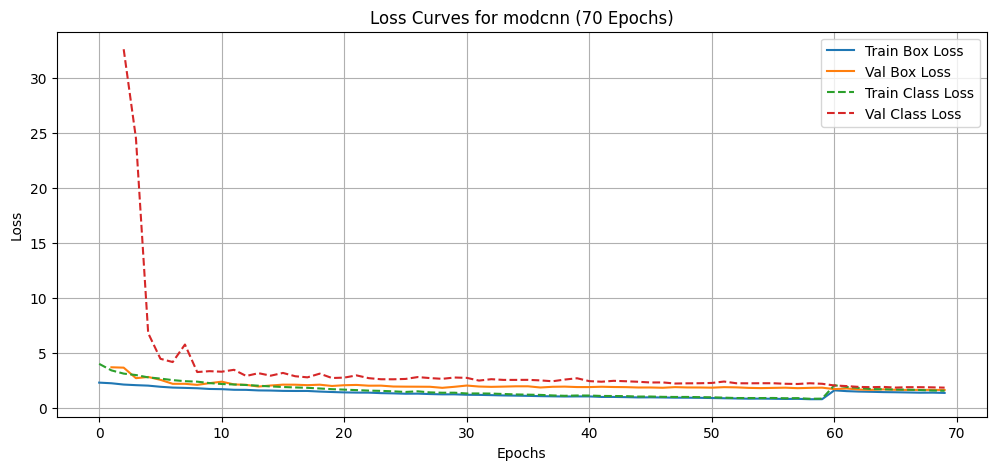

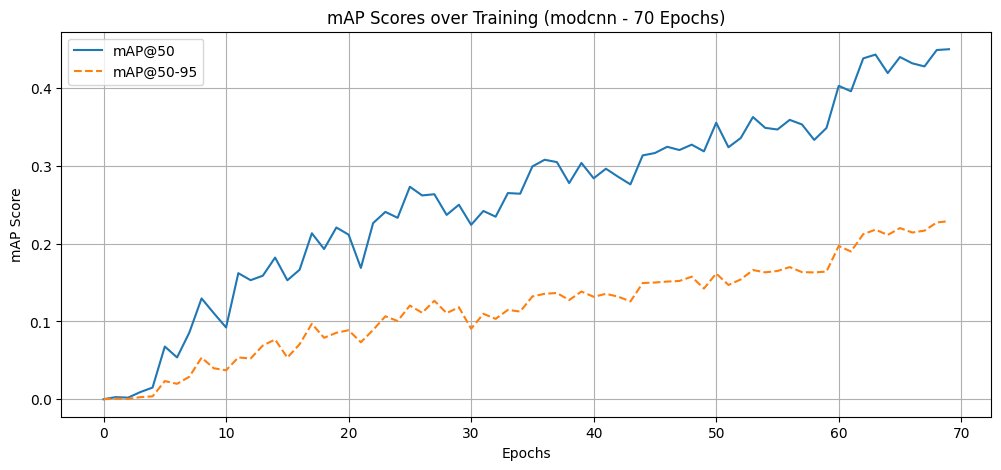

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Update this path if your folder name is different
results_csv_path = "/content/drive/MyDrive/modcnn_results/icratrash_modcnn2/results.csv"

# Load training log
df = pd.read_csv(results_csv_path)

# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.plot(df["train/box_loss"], label="Train Box Loss")
plt.plot(df["val/box_loss"], label="Val Box Loss")
plt.plot(df["train/cls_loss"], label="Train Class Loss", linestyle="dashed")
plt.plot(df["val/cls_loss"], label="Val Class Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for modcnn (70 Epochs)")
plt.legend()
plt.grid()
plt.show()

# Plot mAP Curves
plt.figure(figsize=(12, 5))
plt.plot(df["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df["metrics/mAP50-95(B)"], label="mAP@50-95", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("mAP Score")
plt.title("mAP Scores over Training (modcnn - 70 Epochs)")
plt.legend()
plt.grid()
plt.show()

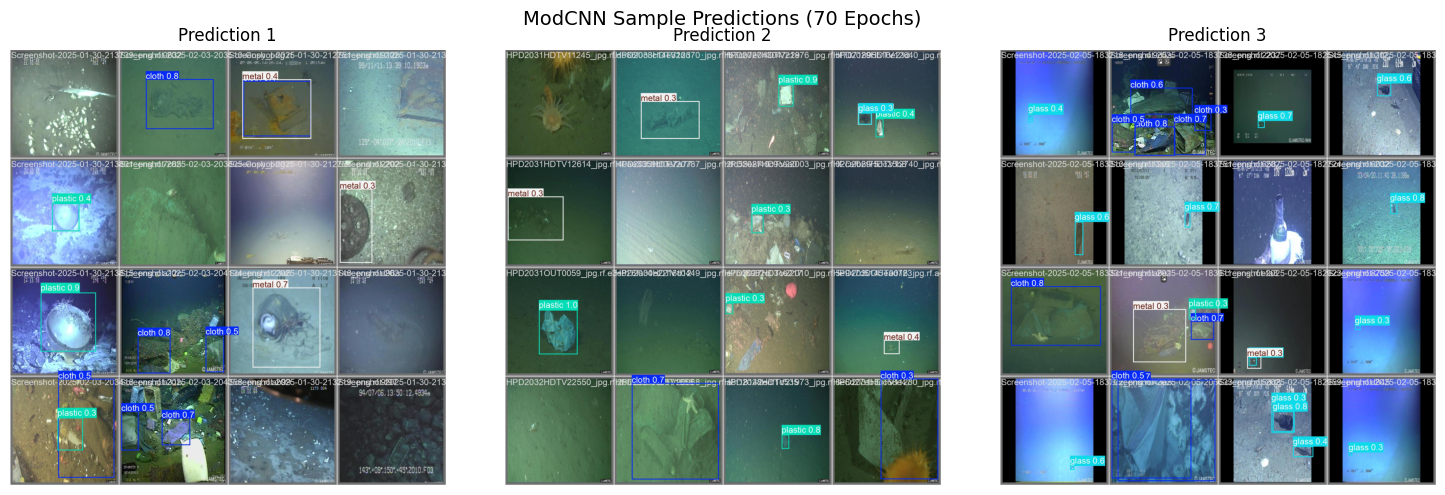

In [20]:
import cv2
import random
import os
import matplotlib.pyplot as plt

# Path to predicted sample images
pred_path = "/content/drive/MyDrive/modcnn_results/icratrash_modcnn2"

# Get prediction images (actual prediction visuals, not curves)
image_files = [f for f in os.listdir(pred_path) if "pred" in f and f.endswith((".jpg", ".png"))]
sample_preds = random.sample(image_files, 3)

# Show them
plt.figure(figsize=(15, 5))
for i, file in enumerate(sample_preds):
    img_path = os.path.join(pred_path, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Prediction {i + 1}")
    plt.axis("off")

plt.suptitle("ModCNN Sample Predictions (70 Epochs)", fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
import os
import shutil

# Define paths for YOLOv12
weights_dir = "/content/drive/MyDrive/modcnn_results/icratrash_modcnn2/weights"
backup_path = "/content/drive/MyDrive/modcnn_best.pt"

# Check for best or last weights
if os.path.exists(os.path.join(weights_dir, "best.pt")):
    best_model_path = os.path.join(weights_dir, "best.pt")
elif os.path.exists(os.path.join(weights_dir, "last.pt")):
    best_model_path = os.path.join(weights_dir, "last.pt")
else:
    raise FileNotFoundError("No best or last weights found in the YOLOv12 weights directory!")

# Backup the best model
shutil.copy(best_model_path, backup_path)
print(f"ModCNN best model saved to: {backup_path}")

ModCNN best model saved to: /content/drive/MyDrive/modcnn_best.pt
